# MDPs in pymdptoolbox - Class Assignment

## Introduction

In this practical exercise, we will look at how we can implement MDP planning in a mathematical toolkit, and track the calculation of the rewards for each state via Value Iteration. The following code sets up an MDP environment (the basic case shown in class, shown in the Figure below) and computes the policy for the given MDP using the Value Iteration algorithm.

<img align="center" src="mdp_simple.png"/>

While you can find the code to solve all the questions from this notebook within this repository (if you inspect the files), we strongly suggest you try to solve the coding problems yourself first.

Then we provide a set of questions for you to implement and answer. This assignment is **not graded**.


In [36]:
# The line below is to be used if you have pymdptoolbox installed with setuptools
# import mdptoolbox.example
# Whereas the line below obviate the need to install that
import sys
sys.path.insert(1,'pymdptoolbox/src')
import mdptoolbox.example

import numpy as _np
from gen_scenario import *

"""
(Y,X)
| 00 01 02 ... 0X-1       'N' = North
| 10  .         .         'S' = South
| 20    .       .         'W' = West
| .       .     .         'E' = East
| .         .   .         'T' = Terminal
| .           . .         'O' = Obstacle
| Y-1,0 . . .   Y-1X-1
""" 

shape = [3,4]
rewards = [[0,3,100],[1,3,-100]]
obstacles = [[1,1]]
terminals = [[0,3],[1,3]]
P, RSS, R = mdp_grid(shape=shape, terminals=terminals, r=-3, rewards=rewards, obstacles=obstacles)
vi = mdptoolbox.mdp.ValueIterationGS(P, R, discount=0.99, epsilon=0.001, max_iter=1000, skip_check=True)

vi.run()
#You can check the quadrant values using print vi.V
# print_policy(vi.policy, shape, obstacles=obstacles, terminals=terminals)
display_policy(vi.policy, shape, obstacles=obstacles, terminals=terminals)

→,→,→,◎
↑,◾,←,◎
↑,←,←,↓


## Converting Rewards

In the lecture, we saw that the reward function can be of one of two forms:

- $R(s): \mathcal{S} \mapsto \mathbb{R}$ - where rewards are associated to a single state
- $R(s,a): \mathcal{S} \times \mathcal{A} \mapsto \mathbb{R}$ - where rewards accrue for pairs of states and actions

Your next piece of code will convert from the state-based reward into a state-action immediate reward. In this case, you can consider that the reward of a state-action pair $(s,a)$  for a state $s$ and action $a$ is the immediate reward of the neighboring states $s'$ weighed by the probability of reaching them using action $a$, thus:

$$R(s,a) = \sum_{s'}R(s')P(s,a,s')$$

In [37]:
# Don't forget we import numpy as _np
def r_to_ra(P, R):
    # We start by assuming we have a fixed number of actions (4, the cardinal points)
    # So we need a matrix with SxA dimensions to store the rewards
    RS = _np.zeros([len(P[1]), 4])
    # You will now convert the rewards for single states into rewards for state-action pairs
    ## YOUR CODE START
    
    ## YOUR CODE END
    return RS

The next cell tests the code you just developed to ensure your conversion is sound.

In [43]:
shape = [2,2]
rewards = [[1,1,1]]
obstacles = []
terminals = [[1,1]]
Ptest, RSStest, Rtest = mdp_grid(shape=shape, terminals=terminals, r=-1, rewards=rewards, obstacles=obstacles)

# Let's compare your implementation with the reference one
RA = r_to_ra(Ptest,Rtest)
RA2 = r_to_rs(Ptest,Rtest,terminals,obstacles,shape)
print("Expected:", str(RA2))
print("Actual:", str(RA))
assert((RA == RA2).all())


Expected: [[-3.  -3.  -3.  -3. ]
 [-3.   0.2 -2.6 -2.6]
 [-2.6 -2.6  0.2 -3. ]
 [ 1.   1.   1.   1. ]]
Actual: [[-3.  -3.  -3.  -3. ]
 [-3.   0.2 -2.6 -2.6]
 [-2.6 -2.6  0.2 -3. ]
 [ 1.   1.   1.   1. ]]


## The Bellman Operator

We are now going to implement the Bellman Operator, recall that there are many forms of the Bellman equation. At its simplest, it specifies, for each state, the expected discounted reward of a policy as a function of the value of their reachable neighbors.
$$v_{\pi}(s) = \mathcal{R}_{s}^{\pi(s)} + \gamma\sum_{s' \in \mathcal{S}}\mathcal{P}_{ss'}^{\pi(a)}v_{\pi}(s)$$

Similarly, the Bellman optimality equation consists of choosing actions greedily at each state:
$$v_{*}(s) = \max_{a \in \mathcal{A}}\left[\mathcal{R}_{s}^{a} + \gamma\sum_{s' \in \mathcal{S}}\mathcal{P}_{ss'}^{a}v_{*}(s)\right]$$

Below, you will implement the Bellman Optimality operator assuming a reward function of the form $R(s,a)$

In [51]:
# Bellman operator


def bellmanOperator(P, R, V, discount=0.9):
    """The Bellman Optimality Operator. 
    input:
    P -> AxSxS transition matrix indicating P(s' | s, a)
    R -> AxS reward function indicading R(S,A)
    V -> S a value function in matrix form
    discount -> [0,1] the discount factor
    """
    Vp = _np.zeros(P.shape[0])
    ## YOUR CODE START

    ## YOUR CODE END
    return pi, Vp


We will now test your implementation of the Bellman operator

In [52]:
from mdptoolbox.mdp import MDP

shape = [2,2]
rewards = [[1,1,1]]
obstacles = []
terminals = [[1,1]]
Ptest, RSStest, Rtest = mdp_grid(shape=shape, terminals=terminals, r=-1, rewards=rewards, obstacles=obstacles)

# Let's compare your implementation with the reference one
V = _np.zeros(4)
pi1, V1 = bellmanOperator(Ptest, RSStest, V, 0.9)
mdp = MDP(Ptest,RSStest,.9,.001,10,False)
pi2, V2 = mdp._bellmanOperator(V)

print("Expected V:", str(V2))
print("Actual V:", str(V1))
assert((V1 == V2).all())
print("Expected policy")
display_policy(pi2, shape, obstacles=obstacles, terminals=terminals)
print("Actual policy")
display_policy(pi1, shape, obstacles=obstacles, terminals=terminals)
assert((pi1 == pi2).all())

Expected V: [-1.   0.6  0.6  1. ]
Actual V: [-1.   0.6  0.6  1. ]
Expected policy


↑,↓
→,◎


Actual policy


↑,↓
→,◎


## Value Iteration

Finally, we will implement a simplified version of the value iteration algorithm, which consists of using the Bellman optimality equation (which you just implemented) until the value function converges to within an error bound $\epsilon$.
At each iteration, you should compare the ```max_norm``` difference between consecutive value functions (which we call ```delta```, or $\delta$), with the bound established by the algorithm $\frac{\epsilon(1 - \gamma)}{\gamma}$

In [108]:
# This returns the span of an array
def max_norm(a):
    return a.max() - a.min()

def valueIteration(P, R, discount=0.9, epsilon=0.01):
    delta = float("inf")
    v = _np.zeros(R.shape[1])
    pi = _np.zeros(R.shape[1])
    ## YOUR CODE START

    ## YOUR CODE END
    return pi, v


We can now test your implementation of the value iteration algorithm against the reference implementation.

In [109]:
from mdptoolbox.mdp import MDP

shape = [2,2]
rewards = [[1,1,1]]
obstacles = []
terminals = [[1,1]]
Ptest, RSStest, Rtest = mdp_grid(shape=shape, terminals=terminals, r=-1, rewards=rewards, obstacles=obstacles)

pi1, v1 = valueIteration(Ptest,RSStest, 0.9, 0.01)
vi = mdptoolbox.mdp.ValueIteration(Ptest, RSStest, discount=0.9, epsilon=0.01, max_iter=1000, skip_check=True)
vi.run()

pi2 = vi.policy
v2 = vi.V
print("Expected V:", str(v2))
print("Actual V:", str(v1))
assert((v1 == v2).all())

print("Expected policy")
display_policy(pi2, shape, obstacles=obstacles, terminals=terminals)
print("Actual policy")
display_policy(pi1, shape, obstacles=obstacles, terminals=terminals)
assert((pi1 == pi2).all())

Expected V: (3.2870658918037767, 5.405540782659857, 5.405540782659857, 6.12579511)
Actual V: [3.28706589 5.40554078 5.40554078 6.12579511]
Expected policy


→,↓
→,◎


Actual policy


→,↓
→,◎


Here we plot the difference between each iteration of the Value Iteration algorithm using many different discount factors. To plot this image, you must install seaborn. To install seaborn run: 

```
pip3 install seaborn --user

```

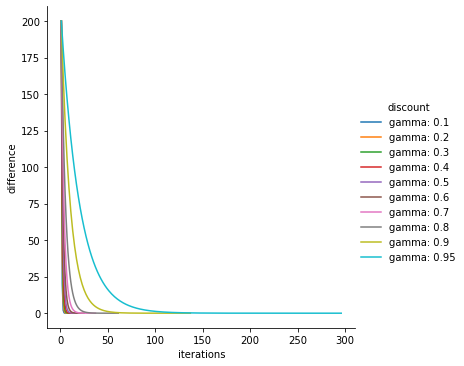

In [28]:
def plot(P, R, discounts=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95], epsilon=0.001, max_iter=1000):
    data_list = []
    import pandas as pd
    from matplotlib import pyplot as plt
    %matplotlib inline
    import seaborn as sns
    data_list = []
    for d in discounts:
        vis = mdptoolbox.mdp.ValueIteration(P, R, d, epsilon, max_iter, skip_check=True)
        vis.run()
        iterations = 1
        for value in vis.iterations_list:
            data_list.append([value, 'gamma: ' + str(d), iterations])
            iterations +=1
    data_frame2 = pd.DataFrame(data_list, columns=['difference', 'discount', 'iterations'])
    ax = sns.relplot(x = 'iterations', y = 'difference', hue='discount', kind="line", data=data_frame2)
plot(P,R)



You can use the following commands to check the difference of value-function values during each teration and the values of each value function.


In [29]:
print(vi.iterations_list)
print(vi.v_list[-1])

[200.0, 198.0, 196.01999999999998, 194.0598, 192.11920199999997, 190.19800997999994, 188.29602988019997, 186.41306958139808, 184.548938885584, 182.70344949672813, 180.87641500176073, 179.0676508517431, 177.2769743432259, 175.5042045997934, 173.7491625537955, 172.0116709282579, 170.2915542189753, 168.5886386767852, 166.90275229001736, 165.2337247671171, 163.58138751944625, 161.9455736442519, 160.32611790780902, 158.72285672873113, 157.1356281614435, 155.564271879829, 154.00862916103142, 152.46854286942107, 150.9438574407268, 149.434418866319, 147.9400746776564, 146.46067393087924, 144.99606719157055, 143.54610651965504, 142.1106454544588, 140.68953899991357, 139.28264360991489, 137.88981717381557, 136.51091900207757, 135.14580981205654, 133.7943517139356, 132.45640819679647, 131.1318441148287, 129.8205256736801, 128.52232041694333, 127.23709721277464, 125.96472624064609, 124.70507897823973, 123.45802818845732, 122.2234479065728, 121.00121342750754, 119.791201293232, 118.59328928030027, 

Before you go for the questionnaire, take your time to open the source code of the MDP toolkit we use, specifically, look into these files:
1. [gen_scenario.py](gen_scenario.py) - contains the conversion code to make the simple coordinate commands above (e.g. ```shape = [3,4]```) into the matrices actually used by the MDP solver
2. [mdp.py](pymdptoolbox/src/mdptoolbox/mdp.py) - contains most of the logic for an MDP, including the *Bellman Equation* as follows:

$$V(s) = \left[ \max_{a} \gamma \sum_{s'}P(s'|s,a)*V(s') \right]+ R(s)$$

See if you can identify how this equation is implemented in the ```MDP._bellmanOperator``` with the [mdp.py](pymdptoolbox/src/mdptoolbox/mdp.py) file. Note how this implementation uses matrix multiplication to achieve the summation step described in the equation. Once you believe you understand that, go ahead and respond the questionnaire. 

### Questionnaire
1. Study the code of the cell above and answer the following questions.
	1. What is the policy generated if we change the discount factor of the grid domain to ```0.1```?
	2. Use the following line ```vi.verbose = True``` before ```vi.run()```:   
	What is the variation for each of the first three iterations with the discount factor of ```0.9``` and how many iterations does the algorithm take to converge?
	3. How does changes to the discount factor affect the variation of the state values over time?

In [30]:
#1.A

In [31]:
#1.B

In [32]:
#1.C

2. The scenario below has an interesting structure whereby the positive rewarding terminal state is partially surrounded by negatively-rewarding states. Program this scenario in pymdptoolbox and compute the optimal policy with a discount factor of 0.99.

<img align="center" src="mdp-odd.png"/>




In [33]:
#2

3. Define two new 5 by 5 scenarios with multiple obstacles and an interesting geometry following the guidelines below. Calculate the policy with discount factor 0.99, and then try to explain intuitively the reason for the resulting policies, given the initial parameters. These two scenarios must have the following characteristics:
	1. A scenario with one (or more) terminal states with positive rewards and at least one other state with the same amount of, but negative reward and no terminal states with negative rewards.
	2. A scenario with one terminal state with a negative reward and at least one non-terminal state with a positive reward.

In [34]:
#3.A

In [35]:
#3.B